# Import Libraries, Load Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations
import matplotlib.dates as mdates
from datetime import datetime

In [5]:
# Paths:
price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
#price_path = "C:/Users/lukee/Downloads/price_data_from_shardar.csv"
#cap_path = "C:/Users/lukee/Downloads/cap_data_from_shardar.csv"

# Reading Data:
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

# Drop troubled stock...
prices_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)
caps_df.drop(["MGI", "MDLZ", "DWA", "ICE"], axis=1, inplace=True)

In [6]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[-1]

# Download additional data:
spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

# Set up dataframes:
prices_with_market = prices_df.merge(spy_data, how='left', left_index=True, right_index=True)
# df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


# Function Definitions

In [7]:
# Function to find the top ten largest market cap stocks
def find_top_liquid_stocks(dataframe, date_start, date_end, num_stocks):
    target_date = date_end + 1
    selected_row = caps_df.iloc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(num_stocks).index.tolist()
    return stocks_list

In [8]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff()#.dropna()
    filtered_df = filtered_df.dropna()
    return filtered_df

In [9]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [10]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [11]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    D = np.diag(A.sum(axis=1))
    L = D - A
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    # Cluster diagram:
    # fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    # scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    # unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
    #        for value in unique_labels.values()]
    # labels = unique_labels.keys()
    # ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    # ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    # plt.show()

    return cluster_dict


In [12]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append((stock1, stock2))
    return cointegrated_pairs

In [13]:
# Function to check on existing pairs
def is_still_cointegrated(dataframe, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [14]:
# weekly function to calculate the beta of the pair
def calculate_beta_for_pair(dataframe, pair):
    asst1 = pair[0]
    asst2 = pair[1]

    train = dataframe[[asst1, asst2]]

    beta = train.cov().iloc[0, 1]/train[asst2].var()
    return beta

In [15]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    # df = dataframe[date_start:date_end]
    beta_values = []
    columns = []

    df_var = dataframe['SPY'].var()

    for stk in stocks_list:
        df_cov = dataframe[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')
        
    # print(dataframe[stocks_list])

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = dataframe.index[:1]

    # plt.figure(figsize=(12, 4))
    # sns.boxplot(data=beta_df)
    # plt.show()

    return beta_df

In [16]:
# Function to get the spread data
def get_spread_limits_for_past_months(dataframe, pair, beta):
    asst1 = pair[0]
    asst2 = pair[1]
    asst1_mean = dataframe[asst1].mean() 
    asst2_mean = dataframe[asst2].mean() 
    spread_data = None
    order = []
    if asst1_mean > asst2_mean:
        spread_data = dataframe[asst1]-beta*dataframe[asst2]
        order = [asst1, asst2]
    else:
        spread_data = dataframe[asst2]-beta*dataframe[asst1]
        order = [asst2, asst1]
    mean = spread_data.mean()
    std_dev = spread_data.std()
    lower_limit = mean - (2*std_dev)
    upper_limit = mean + (2*std_dev)
    
    return upper_limit, lower_limit, order, mean

In [17]:
def print_spread_charts(data_series, upper_bound, lower_bound, mean_value, pair_name):
    # Extract dates and values
    dates = data_series.index
    values = data_series.values
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    
    # Plot the average line
    plt.axhline(y=mean_value, color='blue', linestyle='-', linewidth=1, label='Mean for Past 3 months')
    
    # Plot the dashed lines for ±2 standard deviations
    plt.axhline(y=upper_bound, color='red', linestyle='--', linewidth=1, label='+2 Std Dev')
    plt.axhline(y=lower_bound, color='red', linestyle='--', linewidth=1, label='-2 Std Dev')
    
    # Plot the individual data points
    plt.scatter(dates, values, color='black', zorder=5)
    
    # Annotate the plot
    plt.title(f'Spread data for: {pair_name} for monitoring week')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    
    # Display the plot
    plt.grid(True)
    plt.show()

In [34]:
def print_price_chart(pair, start_date_index, end_date_index):
    global prices_with_market
    stock1 = pair[0]
    stock2 = pair[1]
    prices_with_market[[stock1, stock2]][start_date_index : end_date_index].plot()
    plt.show()
    

In [31]:
def monitor_pair_for_week(pair, pair_dict, start_date_index, end_date_index, curr_week_start_index, currently_monitoring_stocks):
    global prices_with_market
    # Get data
    current_week_price_data = prices_with_market[curr_week_start_index : end_date_index] # 7 days of data
    past_three_month_data = prices_with_market[start_date_index : curr_week_start_index]
    have_days_to_trade = False
    
    if pair_dict["current_hedge_ratio"] is None:
        # Calculate new hedge ratio
        pair_dict["current_hedge_ratio"] = float(calculate_beta_for_pair(past_three_month_data, pair))
    # beta_past_three_months = calculate_beta_for_pair(past_three_month_data, pair)
    upper, lower , pair_order, mean_val = get_spread_limits_for_past_months(past_three_month_data, pair, float(pair_dict["current_hedge_ratio"]))
    curr_week_spread_data = current_week_price_data[pair_order[0]]-float(pair_dict["current_hedge_ratio"])*current_week_price_data[pair_order[1]]
    for index, dayValue in zip(curr_week_spread_data.index, curr_week_spread_data.values):
        if len(pair_dict["open_trade_dates"]) > len(pair_dict["close_trade_dates"]):
            if (pair_dict["trade_day_spread_position"] == "upper" and curr_week_spread_data[index] <= mean_val) or (pair_dict["trade_day_spread_position"] == "lower" and curr_week_spread_data[index] >= mean_val):
                # Found a closing day
                date = index.strftime('%Y-%m-%d')
                pair_dict["close_trade_dates"].append(date)
                pair_dict["trade_status_message"] = "Looking for trading days"
                # currently_monitoring_stocks.remove(pair[0])
                # currently_monitoring_stocks.remove(pair[1])
                pair_dict["trade_day_spread_position"] = "unknown"
                have_days_to_trade = True
        else:
            if curr_week_spread_data[index] >= upper:
                date = index.strftime('%Y-%m-%d')
                pair_dict["open_trade_dates"].append((date, "Selling spread"))
                pair_dict["trade_status_message"] = "Currently in trade"
                pair_dict["trade_day_spread_position"] = "upper"
                # currently_monitoring_stocks.append(pair[0])
                # currently_monitoring_stocks.append(pair[1])
                have_days_to_trade = True
            elif curr_week_spread_data[index] <= lower:
                date = index.strftime('%Y-%m-%d')
                pair_dict["open_trade_dates"].append((date, "Buying spread"))
                pair_dict["trade_status_message"] = "Currently in trade"
                pair_dict["trade_day_spread_position"] = "lower"
                # currently_monitoring_stocks.append(pair[0])
                # currently_monitoring_stocks.append(pair[1])
                have_days_to_trade = True        
                
    # Check if there are open trading days
    if len(pair_dict["open_trade_dates"]) == len(pair_dict["close_trade_dates"]):
        pair_dict["current_hedge_ratio"] = None
    
    if have_days_to_trade:
        print_spread_charts(curr_week_spread_data, upper, lower, mean_val, pair)
        print_price_chart(pair, start_date_index, end_date_index)
    return pair_dict, currently_monitoring_stocks
    

In [19]:
def monitor_group_of_pairs(stock_group_size, stop_after_weeks):
    global prices_with_market
    # List of currently trading stocks
    currently_monitoring_stocks = []
    existing_stocks = {}
    # variable to track the weeks running
    weeks_running = 0
    while (weeks_running < stop_after_weeks):
        print(f"---------------------------- WEEKS RUNNING {weeks_running + 1} -------------------------------------")
        # Calculate index
        start_date_index = ((weeks_running)*7)
        end_date_index = ((weeks_running)*7) + 96
        curr_week_start_index = ((weeks_running)*7) + 89
        # Get data 
        three_month_plus_one_week_df = prices_with_market[start_date_index : end_date_index]
        forward_three_months_data = prices_with_market[start_date_index+6 : end_date_index]
        # Monitor every stock pair that should be monitored in existing_stocks
        for stock_pair in existing_stocks:
            if existing_stocks[stock_pair]['should_monitor']:
                updated_vals, new_currently_monitoring_stocks = monitor_pair_for_week(stock_pair, existing_stocks[stock_pair], start_date_index, end_date_index, curr_week_start_index, currently_monitoring_stocks)
                existing_stocks[stock_pair] = updated_vals
                currently_monitoring_stocks = new_currently_monitoring_stocks
                  
        # Setup for next week
        highly_liquid_stocks = find_top_liquid_stocks(prices_with_market, (start_date_index+7) , (end_date_index), stock_group_size)

        # Grab day string to start or stop trades
        curr_week_date_string = prices_with_market.index[curr_week_start_index].strftime('%Y-%m-%d')
        end_date_string = prices_with_market.index[end_date_index].strftime('%Y-%m-%d')
    
        for stock_pair in existing_stocks:
            # Both stocks must be highly liquid to tradeZ
            if stock_pair[0] in highly_liquid_stocks and stock_pair[1] in highly_liquid_stocks:
                # Check for nulls in data for stock pair
                num_nulls_first_stock = forward_three_months_data[[stock_pair[0]]].isnull().sum().item()
                num_nulls_second_stock = forward_three_months_data[[stock_pair[1]]].isnull().sum().item()
                if num_nulls_first_stock > 0 or num_nulls_second_stock > 0:
                    if existing_stocks[stock_pair]["should_monitor"]:
                        # Determine if stocks are in trade currently
                        if len(existing_stocks[stock_pair]["open_trade_dates"]) > len(existing_stocks[stock_pair]["close_trade_dates"]):    
                            # Close trades
                            existing_stocks[stock_pair]["close_trade_dates"].append(end_date_string)
                            existing_stocks[stock_pair]["trade_day_spread_position"] = "unknown"
                            
                        # Remove stocks from being monitored
                        currently_monitoring_stocks.remove(stock_pair[0])
                        currently_monitoring_stocks.remove(stock_pair[1])
                        existing_stocks[stock_pair]["monitoring_end_dates"].append(end_date_string)
                    
                    # Nulls in the data   
                    existing_stocks[stock_pair]["should_monitor"] = False
                    existing_stocks[stock_pair]["trade_status_message"] = "Nulls in one or more stock price data"
                else:
                    stock_pair_is_coint = is_still_cointegrated(forward_three_months_data, stock_pair, 0.05)
                    if existing_stocks[stock_pair]["should_monitor"]:
                        if stock_pair_is_coint:
                            if len(existing_stocks[stock_pair]["open_trade_dates"]) > len(existing_stocks[stock_pair]["close_trade_dates"]):
                                existing_stocks[stock_pair]["trade_status_message"] = "Currently in trade"
                            else:
                                existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                                
                            existing_stocks[stock_pair]["should_monitor"] = True
                            existing_stocks[stock_pair]["is_cointegrated"] = True
                        else:
                            if len(existing_stocks[stock_pair]["open_trade_dates"]) > len(existing_stocks[stock_pair]["close_trade_dates"]):
                                # Close trades
                                existing_stocks[stock_pair]["close_trade_dates"].append(end_date_string)
                                existing_stocks[stock_pair]["trade_day_spread_position"] = "unknown"
                            # Remove stocks from being monitored
                            currently_monitoring_stocks.remove(stock_pair[0])
                            currently_monitoring_stocks.remove(stock_pair[1])
                            existing_stocks[stock_pair]["should_monitor"] = False
                            existing_stocks[stock_pair]["trade_status_message"] = "Stocks not currently cointegrated"
                            existing_stocks[stock_pair]["monitoring_end_dates"].append(end_date_string)
                            existing_stocks[stock_pair]["is_cointegrated"] = False
                    else:
                        if stock_pair[0] not in currently_monitoring_stocks and stock_pair[1] not in currently_monitoring_stocks:
                            if stock_pair_is_coint:
                                if len(existing_stocks[stock_pair]["monitoring_start_dates"]) == len(existing_stocks[stock_pair]["monitoring_end_dates"]):
                                    # Start new monitoring period
                                    existing_stocks[stock_pair]["monitoring_start_dates"].append(end_date_string)
                                    
                                # Start monitoring pair
                                existing_stocks[stock_pair]["should_monitor"] = True
                                existing_stocks[stock_pair]["is_cointegrated"] = True
                                existing_stocks[stock_pair]["trade_status_message"] = "Looking for trading days"
                                # Add stocks to monitoring list
                                currently_monitoring_stocks.append(stock_pair[0])
                                currently_monitoring_stocks.append(stock_pair[1])
                            else:
                                # This pair will continue to NOT be monitored
                                existing_stocks[stock_pair]["should_monitor"] = False
                                existing_stocks[stock_pair]["is_cointegrated"] = False
                                existing_stocks[stock_pair]["trade_status_message"] = "Stocks not currently cointegrated"
                        else:
                            if stock_pair_is_coint:
                                existing_stocks[stock_pair]["is_cointegrated"] = True
                                existing_stocks[stock_pair]["trade_status_message"] = "One or both stocks are being monitored by another pair"
                            else:
                                existing_stocks[stock_pair]["is_cointegrated"] = False
                                existing_stocks[stock_pair]["trade_status_message"] = "Stocks not currently cointegrated"
            else:
                # Check if pair was being monitored
                if existing_stocks[stock_pair]["should_monitor"]:
                    # Check if stocks in pair are currently in a trade
                    if len(existing_stocks[stock_pair]["open_trade_dates"]) > len(existing_stocks[stock_pair]["close_trade_dates"]):
                        # Close trades
                        existing_stocks[stock_pair]["close_trade_dates"].append(end_date_string)
                        # Remove stocks from being monitored
                        currently_monitoring_stocks.remove(stock_pair[0])
                        currently_monitoring_stocks.remove(stock_pair[1])
                        
                    # Can't monitor because stocks not liquid enough    
                    existing_stocks[stock_pair]["should_monitor"] = False
                    existing_stocks[stock_pair]["monitoring_end_dates"].append(end_date_string)
                    existing_stocks[stock_pair]["trade_day_spread_position"] = "unknown"
                    
                existing_stocks[stock_pair]["current_hedge_ratio"] = None    
                existing_stocks[stock_pair]["trade_status_message"] = "Stocks not liquid enough to trade"
                    
                
        liquid_stocks_not_null = []
        for stock in highly_liquid_stocks:
            num_nulls_for_stock = forward_three_months_data[[stock]].isnull().sum().item()
            if num_nulls_for_stock == 0:
                liquid_stocks_not_null.append(stock)
                
        # Find new pairs for week
        diff_df = filter_diff_df(prices_with_market, (start_date_index+7) , (end_date_index), liquid_stocks_not_null)
        three_month_highly_liquid_stocks_price_df = filter_df_by_dates(prices_with_market, (start_date_index+6) , end_date_index, liquid_stocks_not_null)
        beta_df = calculate_betas(diff_df, (start_date_index+6) , end_date_index, liquid_stocks_not_null)

        merged_df = diff_df.merge(beta_df, how = 'cross')
        res_df = calculate_residuals(merged_df, liquid_stocks_not_null)
        cluster_dict = cluster_the_matrix(res_df, 5)
        new_stock_pairs = find_cointegrated_pairs(three_month_highly_liquid_stocks_price_df, cluster_dict, 0.05)
        
        for stock_pair in new_stock_pairs:
            # Verify that neither order of stocks exist in existing stocks
            stock1, stock2 = stock_pair
            if (stock1, stock2) not in existing_stocks and (stock2, stock1) not in existing_stocks:
                new_stock_pair_dict = {
                                        "is_cointegrated" : True,
                                        "should_monitor" : True,
                                        "trade_status_message" : "Looking for trading days",
                                        "monitoring_start_dates" : [],
                                        "monitoring_end_dates" : [],
                                        "open_trade_dates" : [],
                                        "close_trade_dates" : [],
                                        "trade_day_spread_position": "unknown",
                                        "current_hedge_ratio": None
                                    }
                # Verify stocks in pair are not currently being monitored
                if stock1 in currently_monitoring_stocks or stock2 in currently_monitoring_stocks:
                    new_stock_pair_dict["should_monitor"] = False
                    new_stock_pair_dict["trade_status_message"] = "One or both stocks are being monitored by another pair"
                else:
                    # Now these stocks will be monitored for next week
                    currently_monitoring_stocks.append(stock1)
                    currently_monitoring_stocks.append(stock2)
                    new_stock_pair_dict["monitoring_start_dates"].append(end_date_string)
                    
                existing_stocks[stock_pair] = new_stock_pair_dict
        # Increment weeks_running
        weeks_running +=1
    
    print(currently_monitoring_stocks)
    return existing_stocks
        

In [47]:
def plot_overall_chart(data, prices_with_market):
    # Ensure all dates in the data are in prices_with_market
    all_dates = set(prices_with_market)
    for key, value in data.items():
        all_dates.update(value['monitoring_start_dates'])
        all_dates.update(value['monitoring_end_dates'])
        all_dates.update([date for date, _ in value['open_trade_dates']])
        all_dates.update(value['close_trade_dates'])
    
    # Sort all dates to create a consistent x-axis
    sorted_dates = sorted(all_dates)
    
    # Create a dictionary to map dates to indices
    date_to_index = {date: idx for idx, date in enumerate(sorted_dates)}

    # Function to create a line with given start and end positions
    def create_line(start, end):
        line = ['-'] * (end - start + 1)
        return line

    # Iterate through each key in the dictionary
    for key, value in data.items():
        # Create an empty chart line
        chart_line = [' '] * len(sorted_dates)

        # Plot the monitoring periods
        for start_date, end_date in zip(value['monitoring_start_dates'], value['monitoring_end_dates']):
            start_idx = date_to_index[start_date]
            end_idx = date_to_index[end_date]
            chart_line[start_idx:end_idx + 1] = create_line(start_idx, end_idx)

        # Plot the open trade dates
        for open_trade_date, _ in value['open_trade_dates']:
            open_trade_idx = date_to_index[open_trade_date]
            chart_line[open_trade_idx] = 'G'

        # Plot the close trade dates
        for close_trade_date in value['close_trade_dates']:
            close_trade_idx = date_to_index[close_trade_date]
            chart_line[close_trade_idx] = 'R'

        # Convert chart line to a string
        chart_str = ''.join(chart_line)
        
        # Print the key and the corresponding chart
        print(f"{key[0]}| {chart_str}")

    # Print the x-axis
    x_axis = '    ' + ' '.join(['|'] * len(sorted_dates))
    print(f"    {x_axis}")

# Running Functions

---------------------------- WEEKS RUNNING 1 -------------------------------------
---------------------------- WEEKS RUNNING 2 -------------------------------------


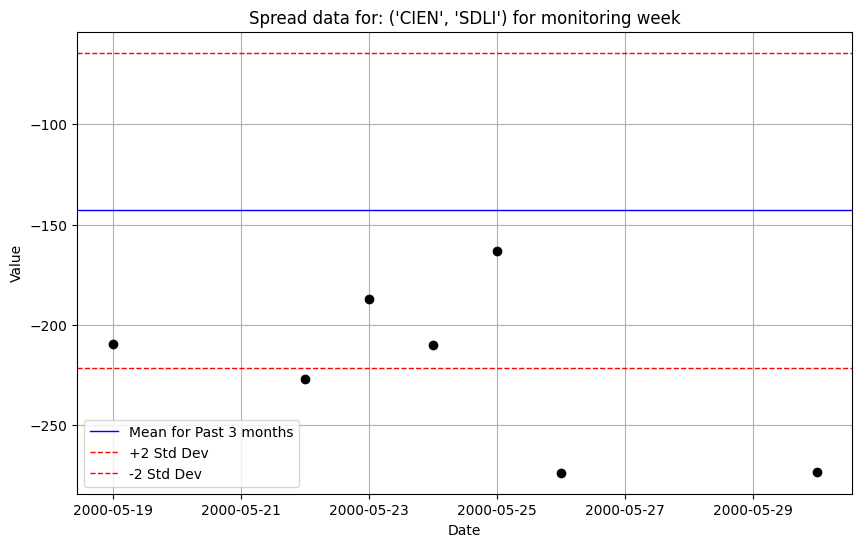

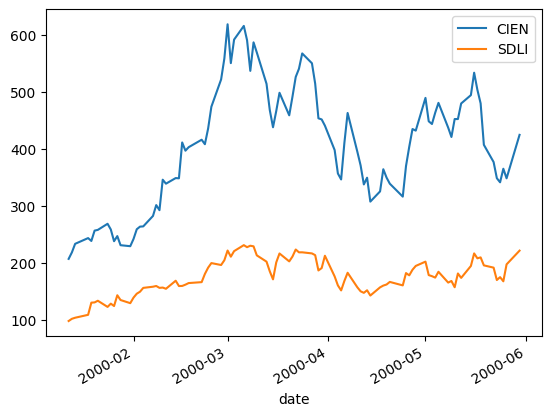

---------------------------- WEEKS RUNNING 3 -------------------------------------
---------------------------- WEEKS RUNNING 4 -------------------------------------


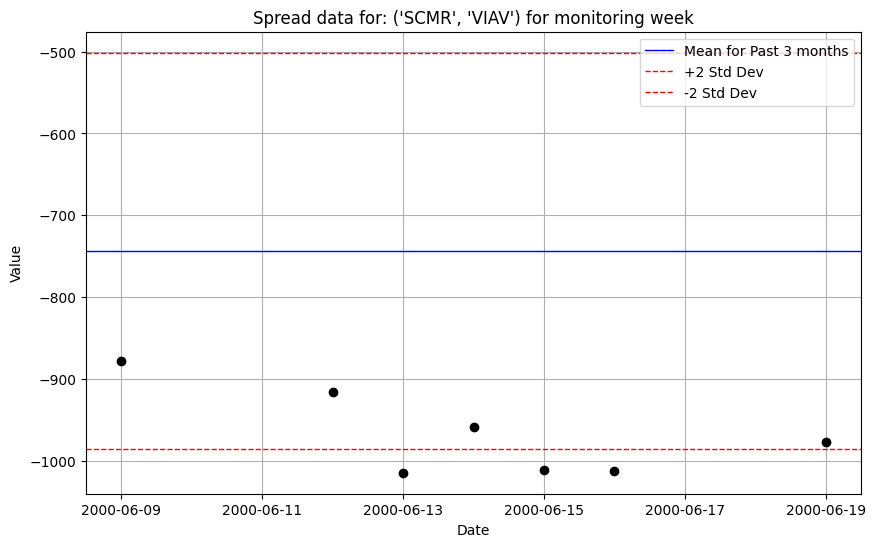

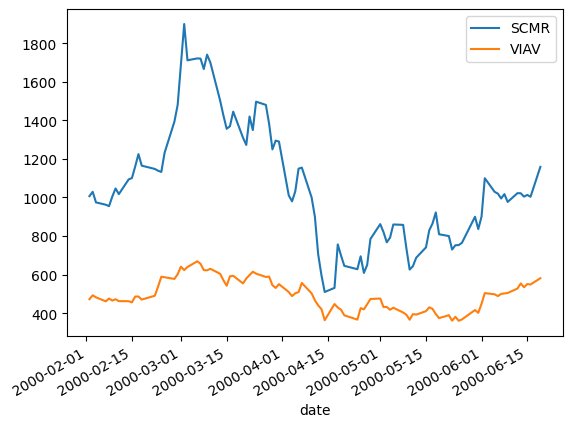

---------------------------- WEEKS RUNNING 5 -------------------------------------


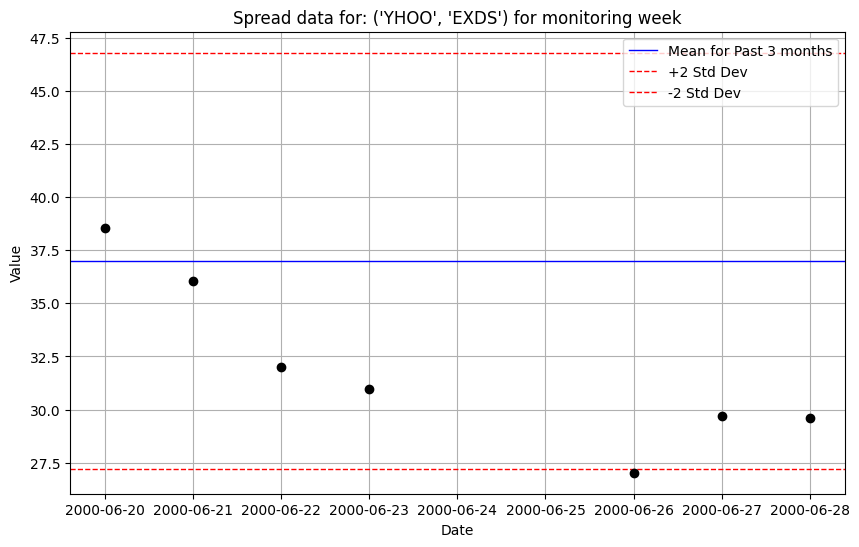

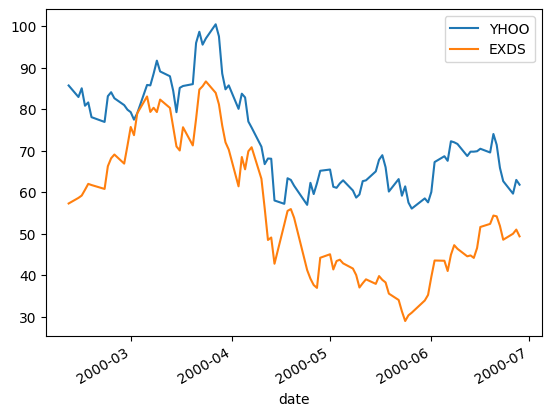

---------------------------- WEEKS RUNNING 6 -------------------------------------


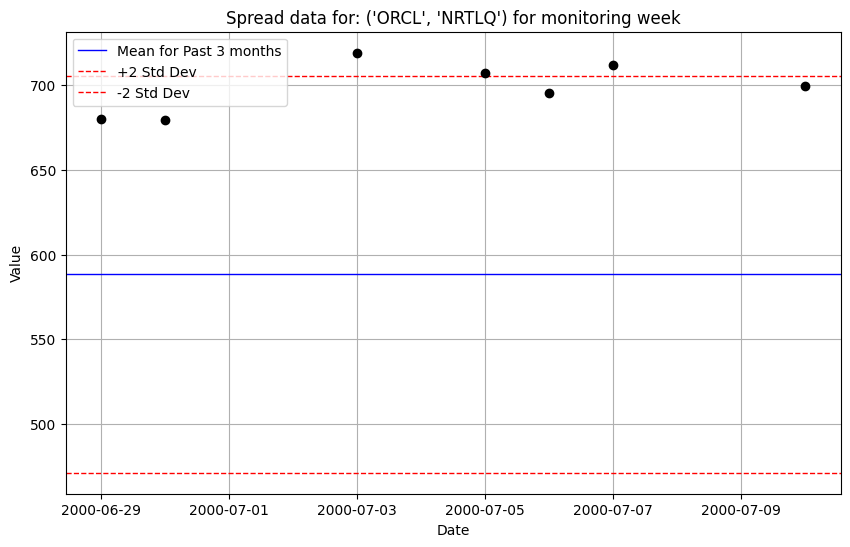

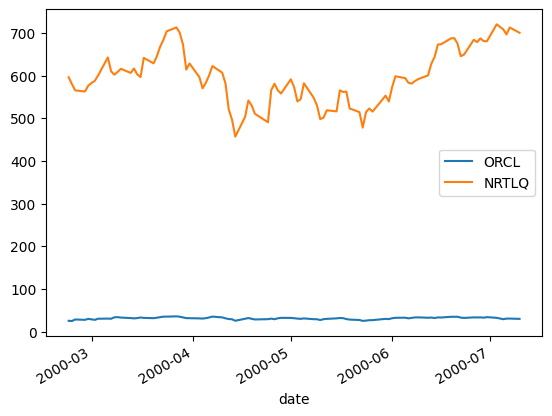

---------------------------- WEEKS RUNNING 7 -------------------------------------


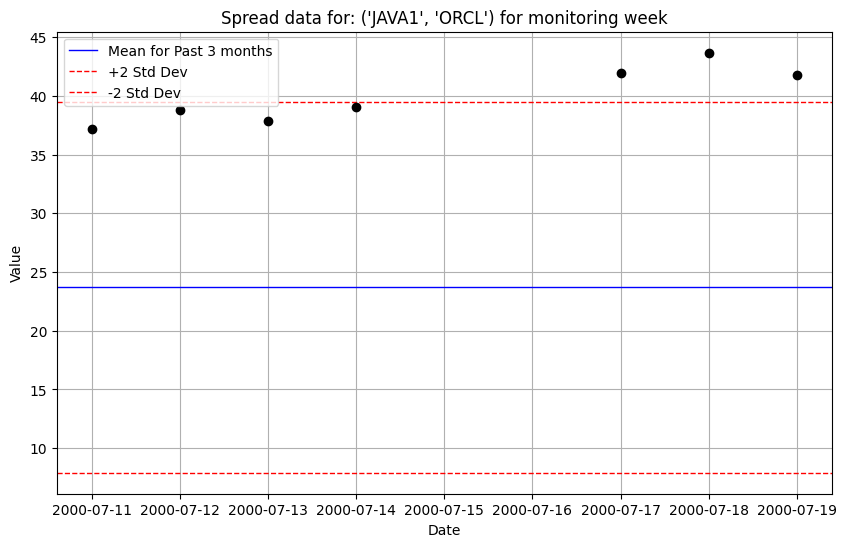

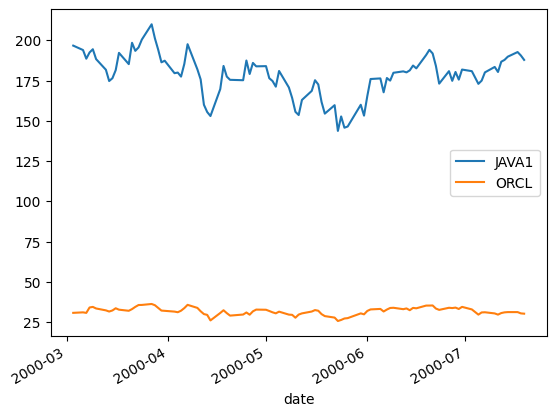

---------------------------- WEEKS RUNNING 8 -------------------------------------


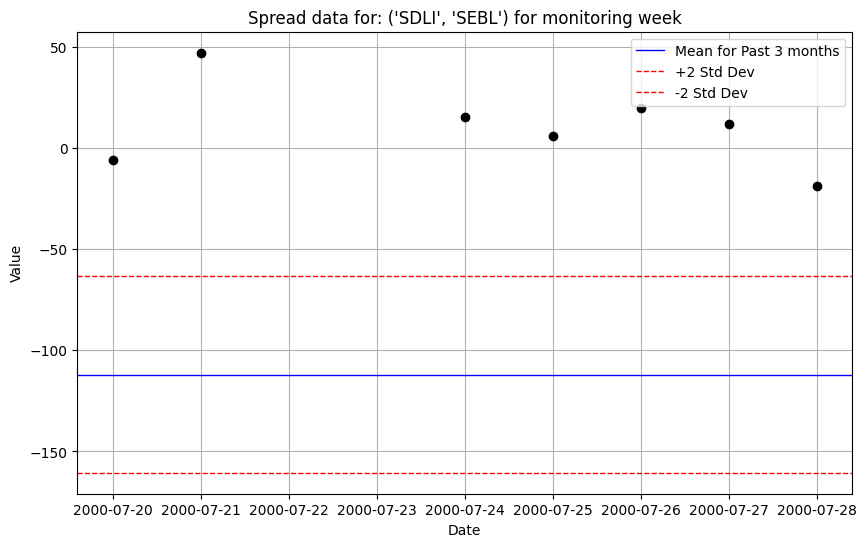

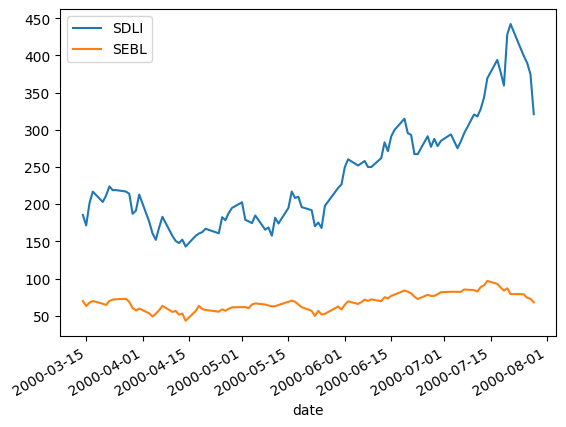

---------------------------- WEEKS RUNNING 9 -------------------------------------


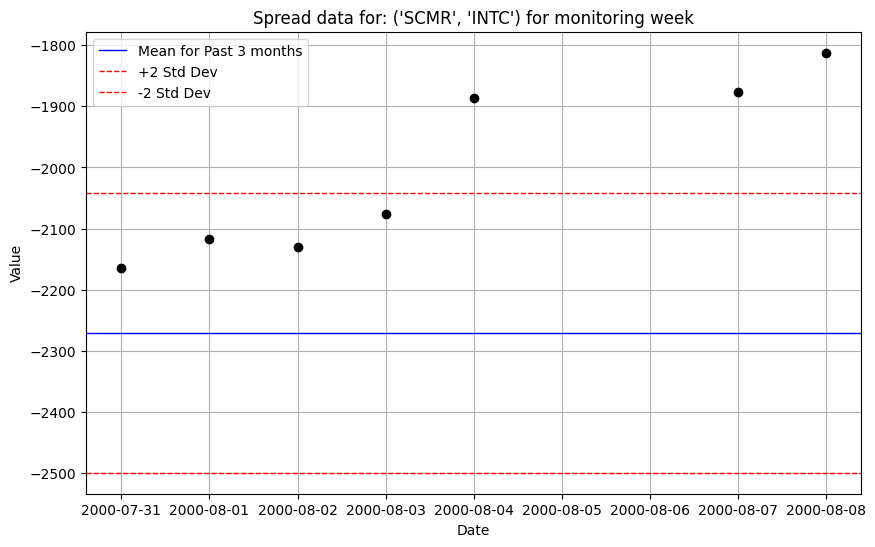

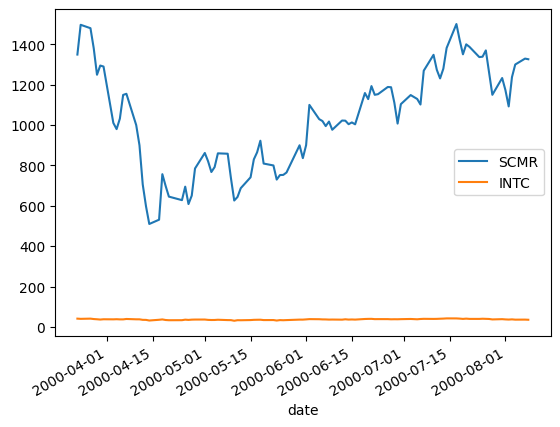

---------------------------- WEEKS RUNNING 10 -------------------------------------


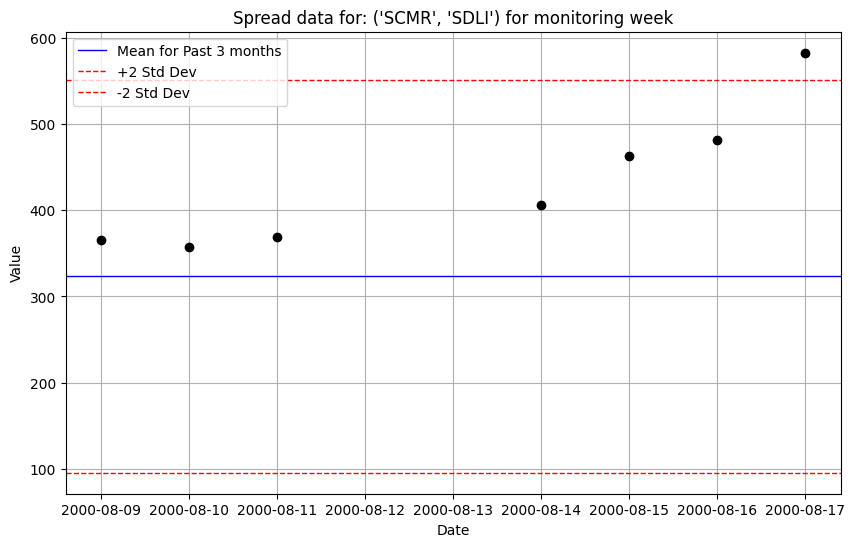

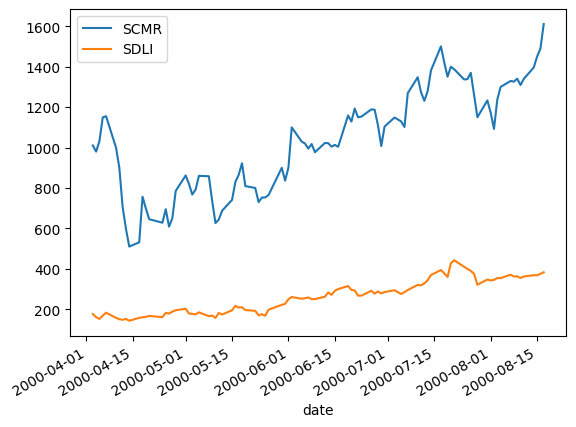

---------------------------- WEEKS RUNNING 11 -------------------------------------
---------------------------- WEEKS RUNNING 12 -------------------------------------


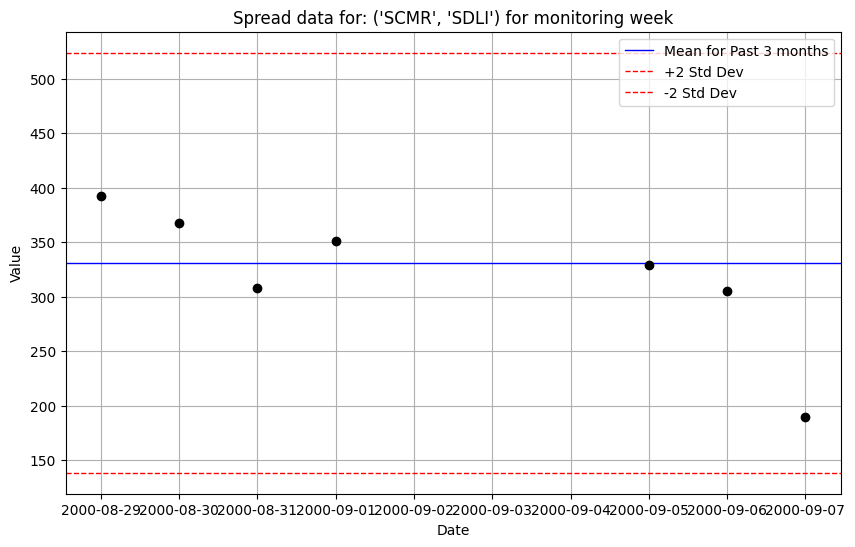

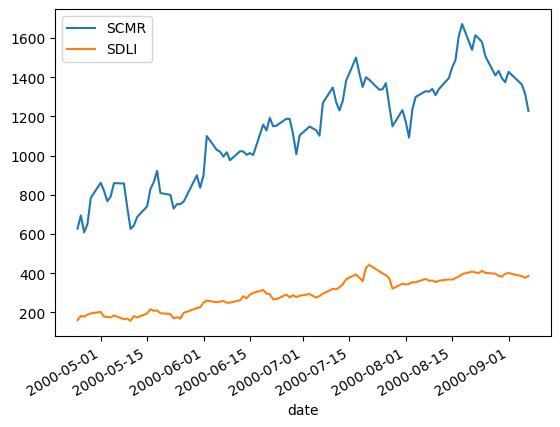

---------------------------- WEEKS RUNNING 13 -------------------------------------


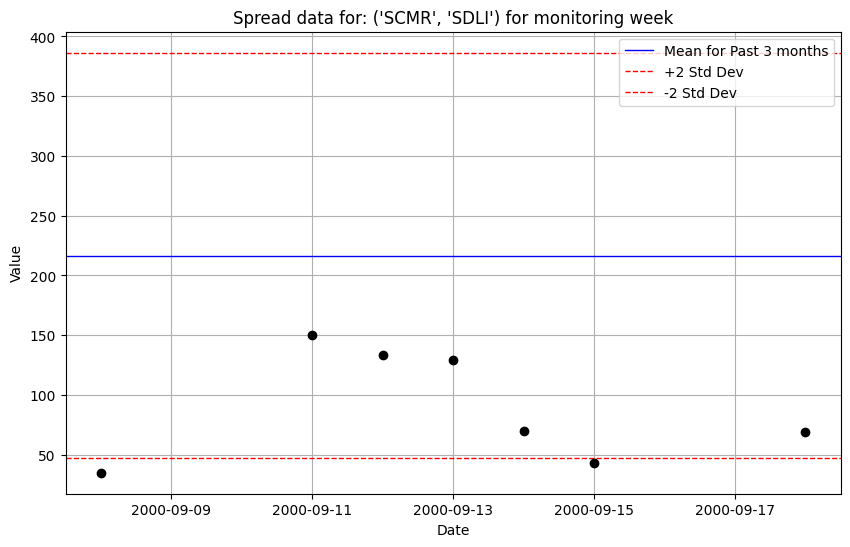

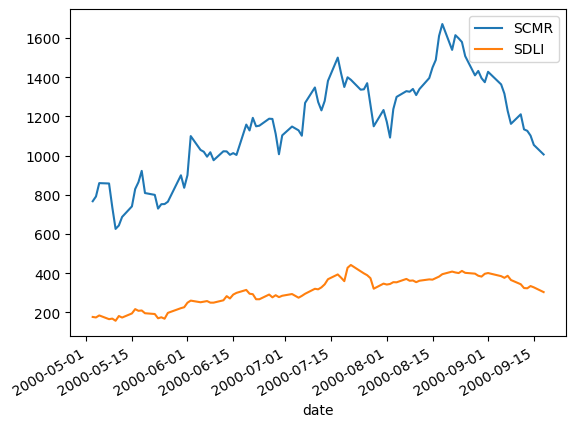

---------------------------- WEEKS RUNNING 14 -------------------------------------


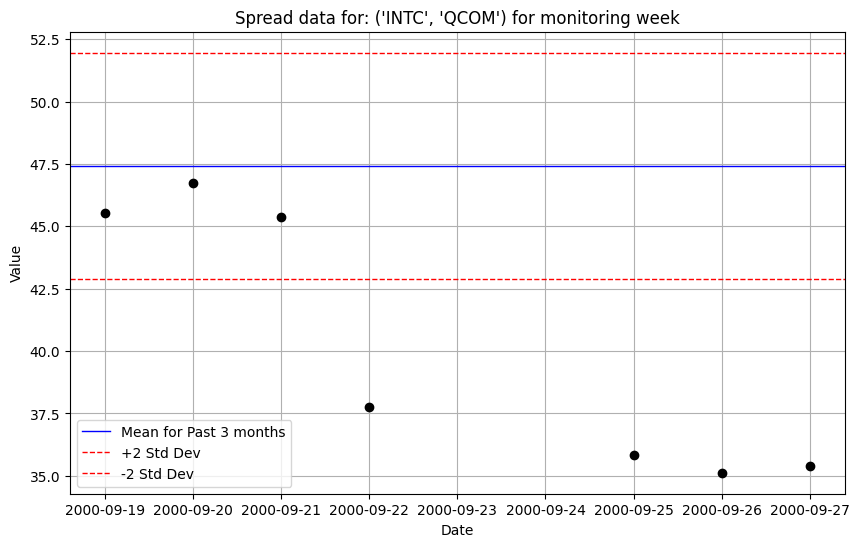

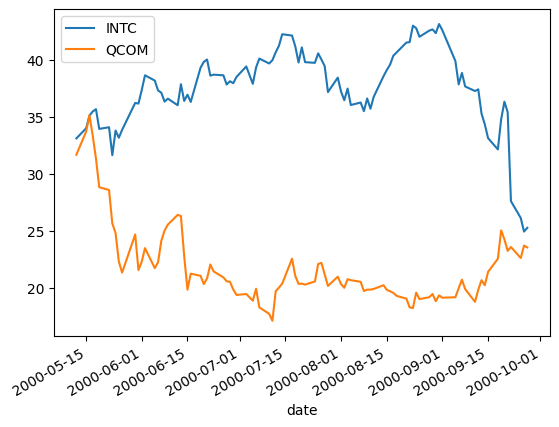

---------------------------- WEEKS RUNNING 15 -------------------------------------


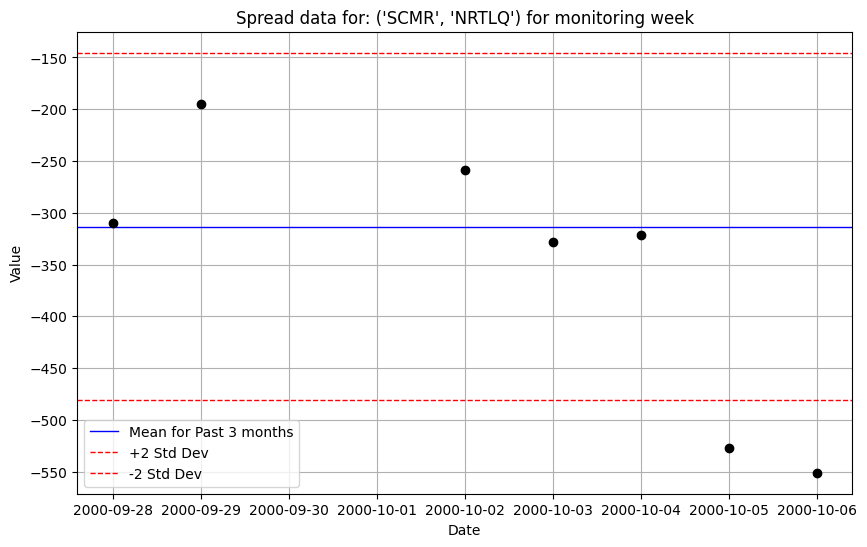

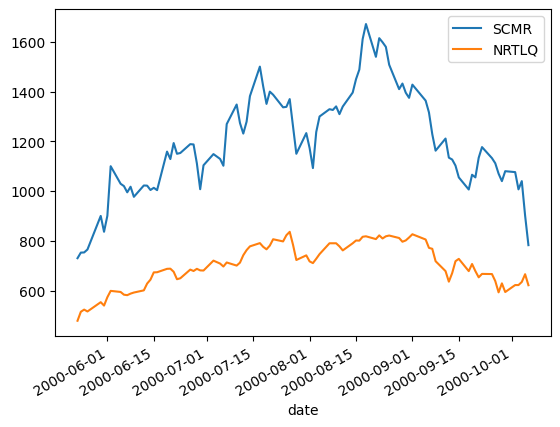

---------------------------- WEEKS RUNNING 16 -------------------------------------
---------------------------- WEEKS RUNNING 17 -------------------------------------
---------------------------- WEEKS RUNNING 18 -------------------------------------


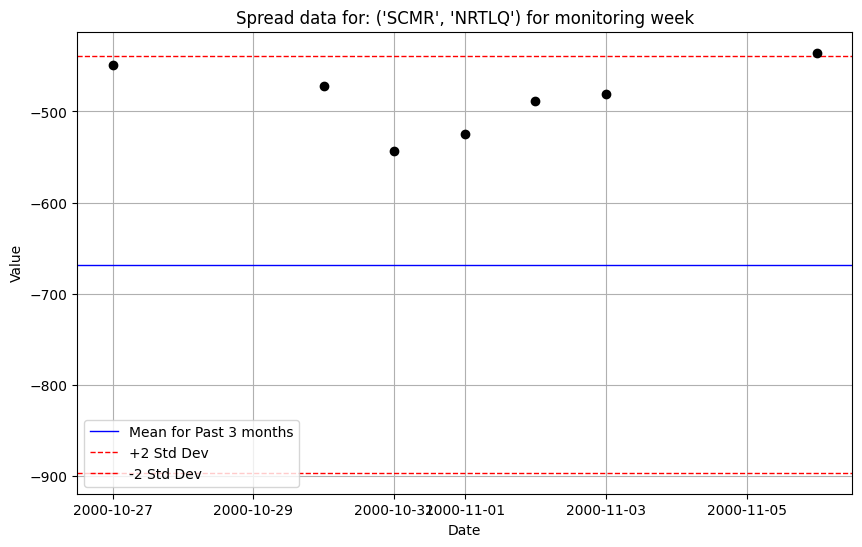

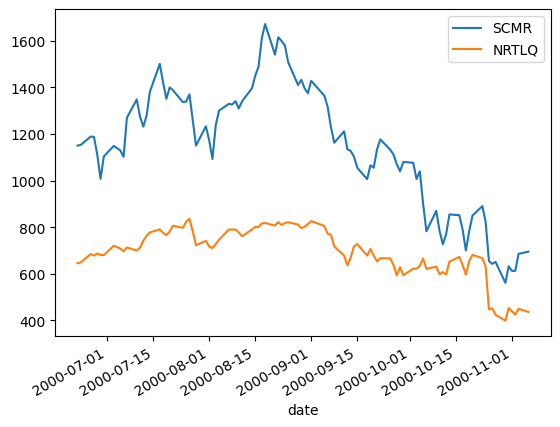

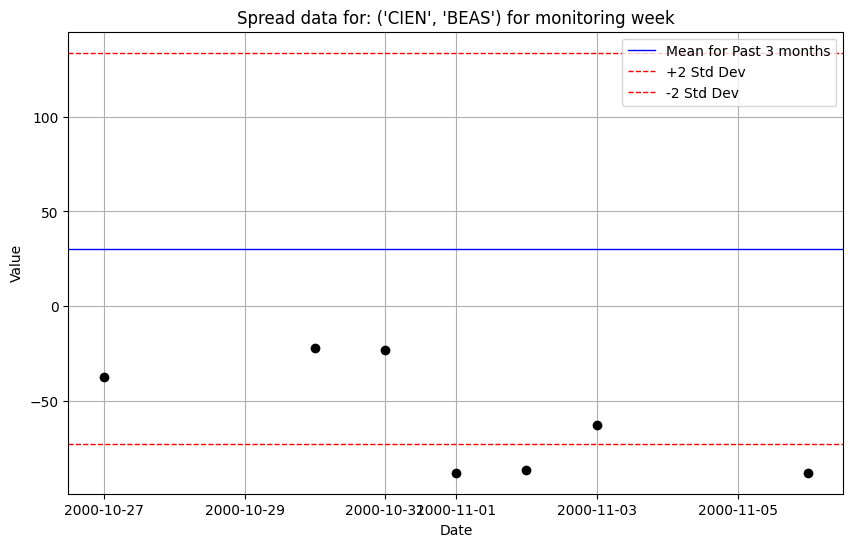

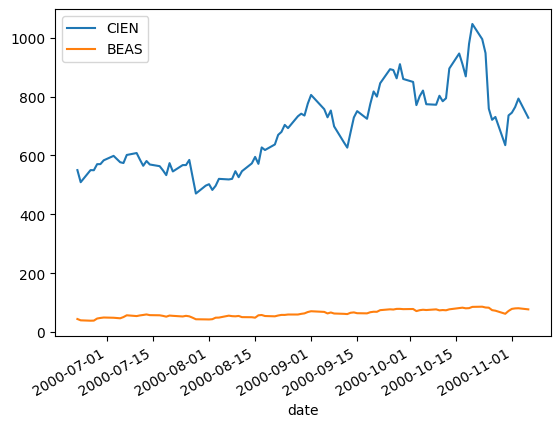

---------------------------- WEEKS RUNNING 19 -------------------------------------
---------------------------- WEEKS RUNNING 20 -------------------------------------


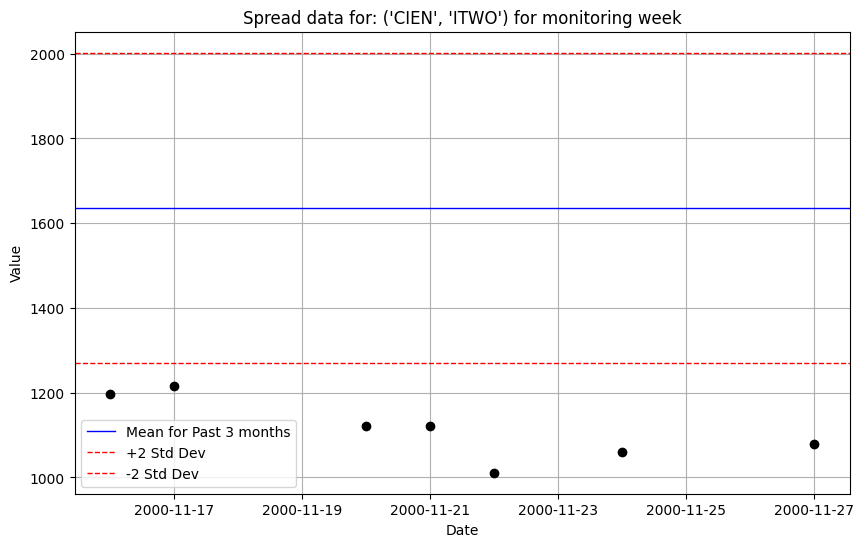

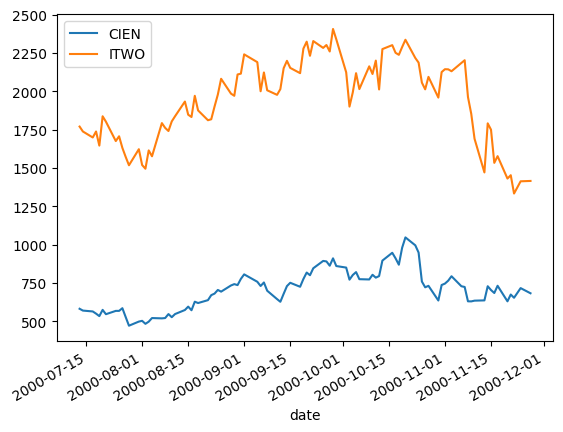

---------------------------- WEEKS RUNNING 21 -------------------------------------
---------------------------- WEEKS RUNNING 22 -------------------------------------


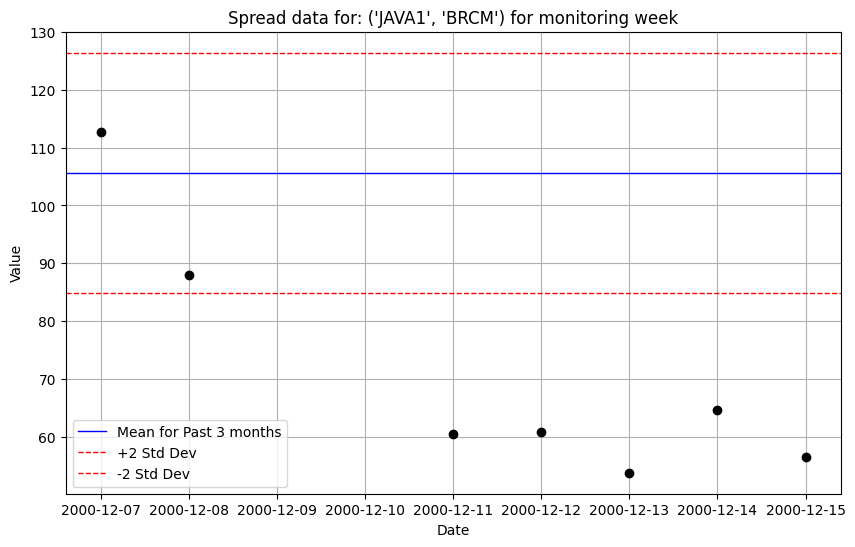

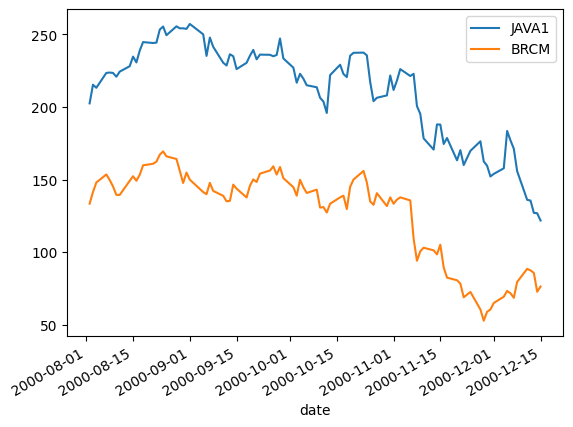

---------------------------- WEEKS RUNNING 23 -------------------------------------


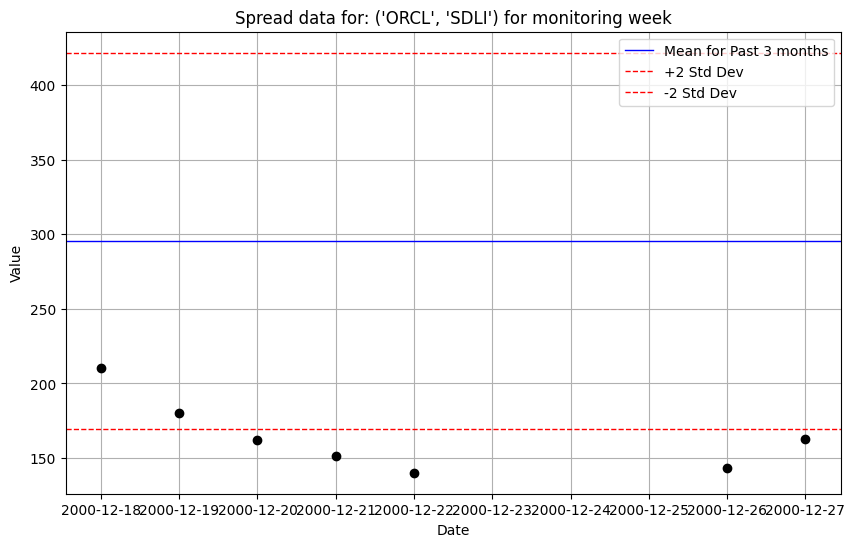

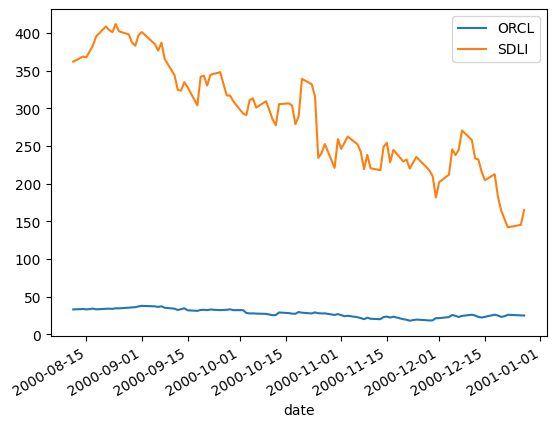

---------------------------- WEEKS RUNNING 24 -------------------------------------
---------------------------- WEEKS RUNNING 25 -------------------------------------
---------------------------- WEEKS RUNNING 26 -------------------------------------
---------------------------- WEEKS RUNNING 27 -------------------------------------
---------------------------- WEEKS RUNNING 28 -------------------------------------


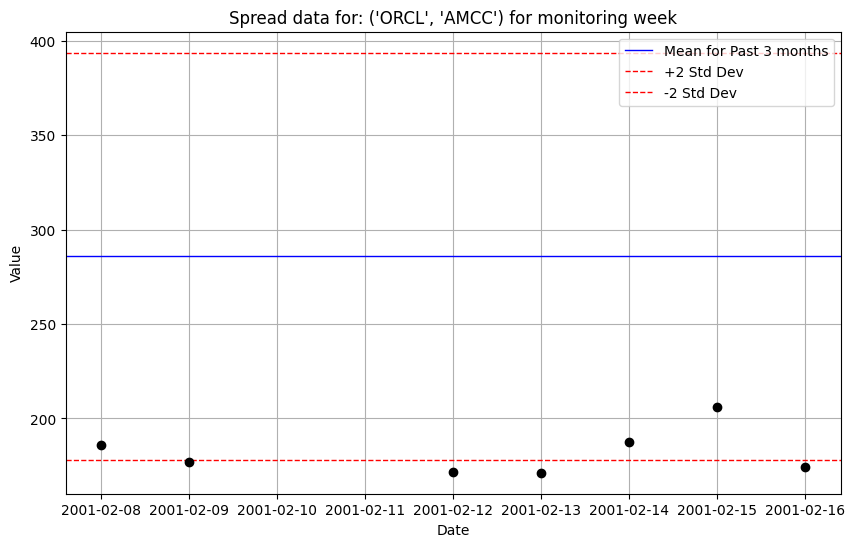

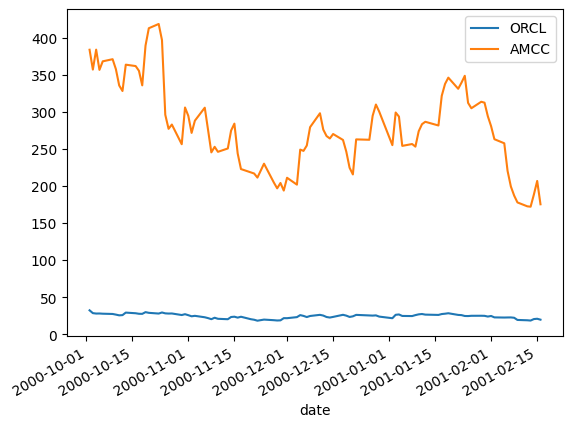

---------------------------- WEEKS RUNNING 29 -------------------------------------
---------------------------- WEEKS RUNNING 30 -------------------------------------
---------------------------- WEEKS RUNNING 31 -------------------------------------
---------------------------- WEEKS RUNNING 32 -------------------------------------
---------------------------- WEEKS RUNNING 33 -------------------------------------
---------------------------- WEEKS RUNNING 34 -------------------------------------
---------------------------- WEEKS RUNNING 35 -------------------------------------
---------------------------- WEEKS RUNNING 36 -------------------------------------
---------------------------- WEEKS RUNNING 37 -------------------------------------
---------------------------- WEEKS RUNNING 38 -------------------------------------
---------------------------- WEEKS RUNNING 39 -------------------------------------
---------------------------- WEEKS RUNNING 40 ------------------------------

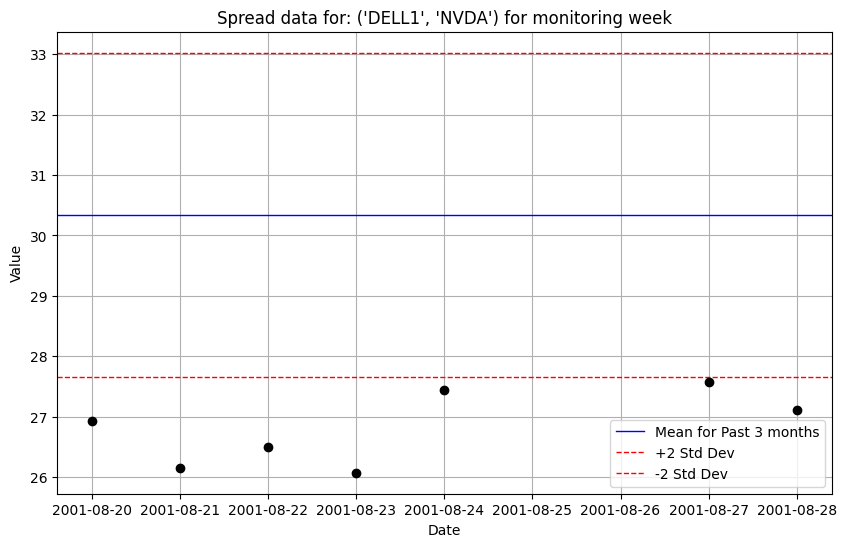

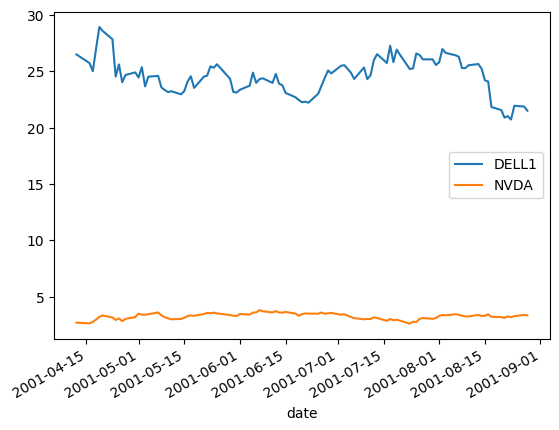

---------------------------- WEEKS RUNNING 48 -------------------------------------
---------------------------- WEEKS RUNNING 49 -------------------------------------


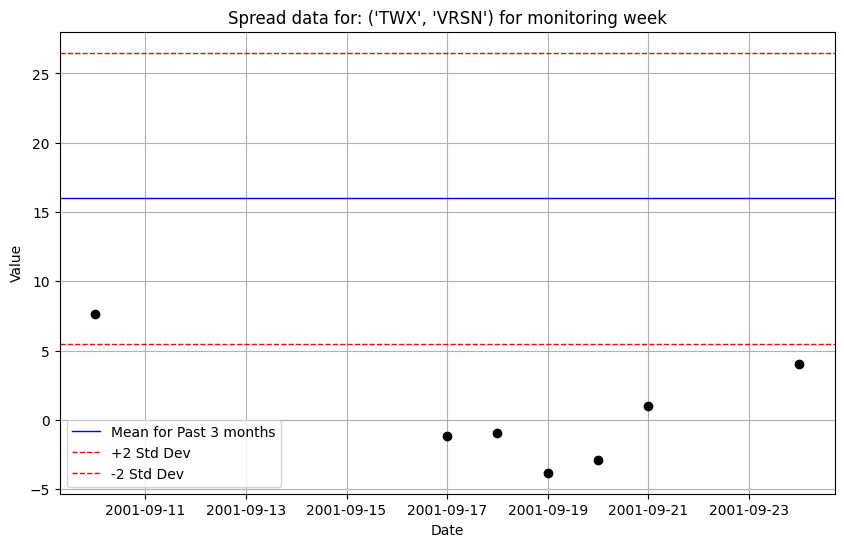

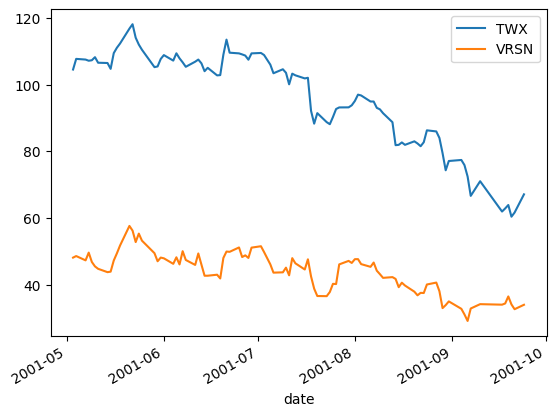

---------------------------- WEEKS RUNNING 50 -------------------------------------
['PMCS', 'BRCD', 'CTXS', 'LVLT', 'JNPR', 'VIAV', 'CSCO', 'EXDS', 'CMVT', 'MU', 'ARBA', 'EMC1', 'SEBL', 'VRTS1', 'SCMR', 'LU1', 'BRCM', 'ITWO', 'INTC', 'QCOM', 'JAVA1', 'BEAS', 'ORCL', 'AMCC', 'AMAT', 'NVLS1', 'IBM', 'PFE']
{('AMAT', 'BA'): {'close_trade_dates': [],
                  'current_hedge_ratio': None,
                  'is_cointegrated': True,
                  'monitoring_end_dates': [],
                  'monitoring_start_dates': [],
                  'open_trade_dates': [],
                  'should_monitor': False,
                  'trade_day_spread_position': 'unknown',
                  'trade_status_message': 'Stocks not liquid enough to trade'},
 ('AMAT', 'CIEN'): {'close_trade_dates': [],
                    'current_hedge_ratio': None,
                    'is_cointegrated': False,
                    'monitoring_end_dates': [],
                    'monitoring_start_dates': [],
     

In [35]:
# results = monitor_group_of_pairs(coint_dict, 5)
import pprint
results = monitor_group_of_pairs(20,50)
pprint.pprint(results)

In [48]:
plot_overall_chart(results, prices_with_market)

SCMR| ----GR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            